In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/dblp-scholar-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/dblp-scholar-reduced/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = [],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine', 'inverse_l1'],
                        text_compositions=['average', 'idf', 'bi_lstm'],
                        numeric_sim_metrics=[],
                        dense_nodes=[32, 16],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False,
                        lstm_args=dict(units=20, dropout=0.25, recurrent_dropout=0.25),
                        batch_norm=True,
                        dropout=0.75,
                        embedding_trainable=True)

Number of inputs to dense layer: 84


# Crash recovery 

In [ ]:
model.load_weights('../data/models/dblp-scholar-base-2t-allcomp-allsim')
df_hist = pd.read_csv('../data/histories/dblp-scholar-base-2t-allcomp-allsim.csv')

histories['acc'] = list(df_hist['acc'].values)
histories['val_acc'] = list(df_hist['val_acc'].values)
histories['loss'] = list(df_hist['loss'].values)
histories['val_loss'] = list(df_hist['val_loss'].values)

# Train model 

In [52]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=2048,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 432038 samples, validate on 54004 samples
Epoch 1/1
432038/432038 [==============================] - 486s 1ms/step - loss: 0.0111 - acc: 0.9981 - val_loss: 0.0021 - val_acc: 0.9997


# Learning curves

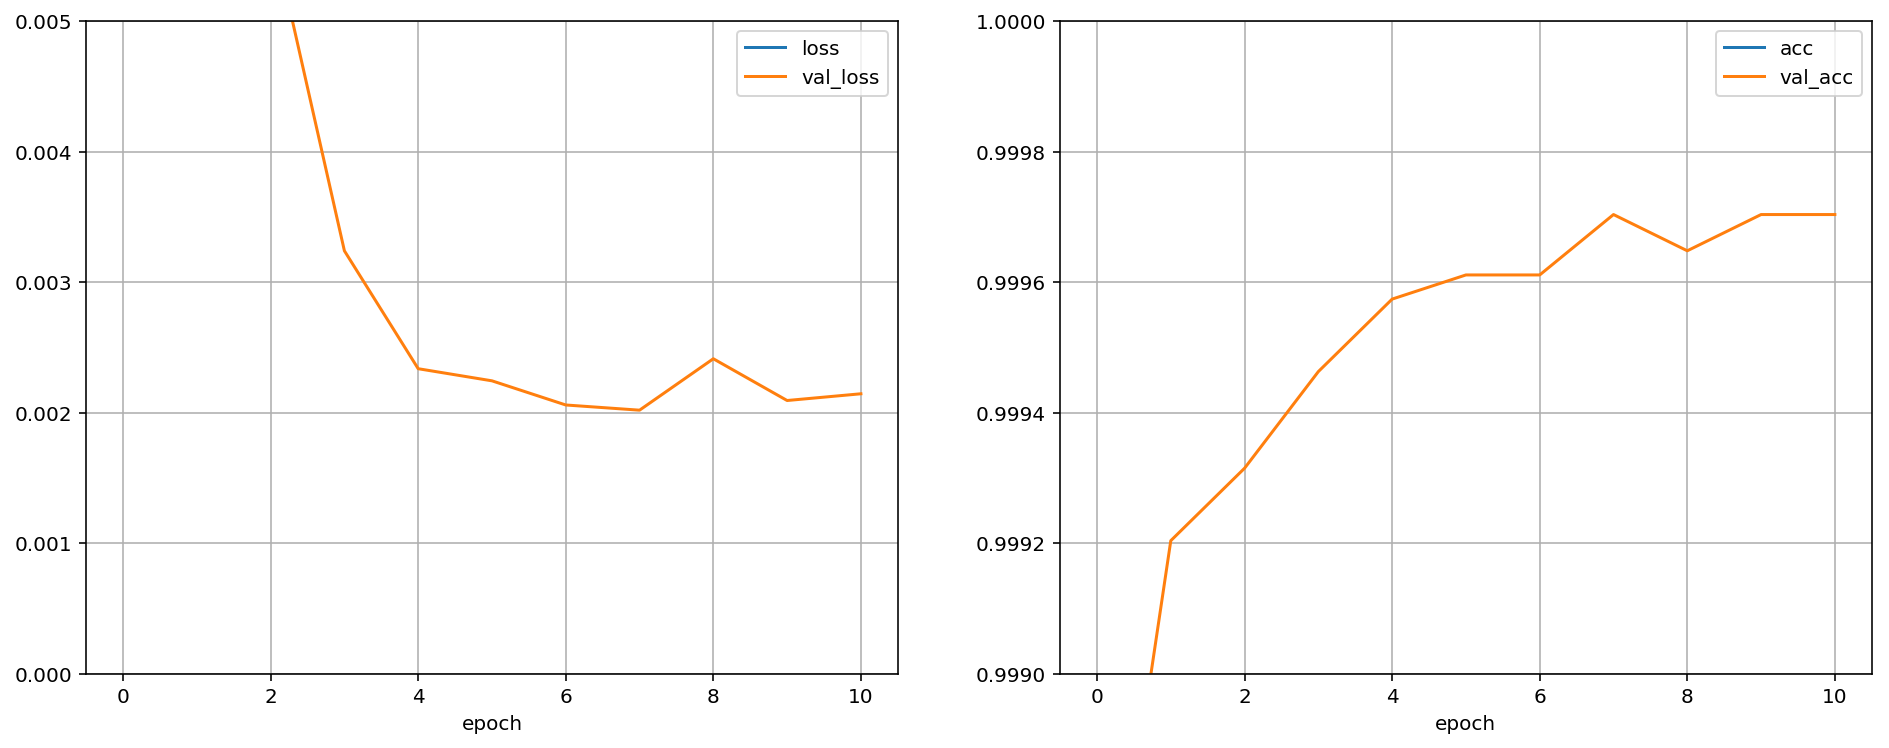

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.005)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(0.999, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [43]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     53474
          1       0.99      0.98      0.98       530

avg / total       1.00      1.00      1.00     54004

[[53468     6]
 [   10   520]]


In [44]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,title,authors,venue,year,id2,title,authors,venue,year
7157,conf/vldb/BonczMK99,database architecture optimized for the new bottleneck memory access,boncz manegold kersten,vldb,1999,6GAoBRINv7kJ,databasearchitecture optimizedforthenewbottleneck memoryaccess,boncz manegold kersten,25th international conference on very large data bases,0.0
27714,journals/vldb/C94c,title foreword preface to the special issue on spatial database systems index,nan,nan,1994,url:http://portal.acm.org/citation.cfm%3Fid%3D615204.615205%26dl%3Dportal%26dl%3DACM%26type%3Dissue%26idx%3DJ869%26part%3Dperiodical%26WantType%3Dperiodical%26title%3DThe%2520VLDB%2520Journal%2520%2526mdash%253B%2520The%2520International%2520Journal%2520on%2520Very%2520Large%2520Data%2520Bases%26CFID%3D11111111%26CFTOKEN%3D2222222,special issue on spatial database systems,hj schek,the vldb the international journal on very large,1994.0
11699,conf/sigmod/ZhaoDNS98,simultaneous optimization and evaluation of multiple dimensional queries,zhao deshpande naughton shukla,sigmod conference,1998,6AK0GF7jAtsJ,pm deshpande jf naughton shukla simultaneous optimization and evaluation of multiple,zhao,acm sigmod,0.0
17181,journals/sigmod/CasatiDS00,vldb workshop on technologies in tes,nan,nan,2000,pJsnj7fi9LIJ,report on the vldb workshop on technologies for tes cairo egypt september 14 and 15,casati,sigmod record,2000.0
26814,conf/vldb/GyssensL97,foundation for databases,gyssens lakshmanan,vldb,1997,CfujBHjOpPAJ,foundation for in dayal gray pmd nishio eds,gyssens lvs lakshmanan,nan,1997.0


# Save model and histories 

In [45]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-base-2t-allcomp-allsim.csv', index=False)
model.save_weights('../data/models/dblp-scholar-base-2t-allcomp-allsim')

# Test model 

In [4]:
model.load_weights('../data/models/dblp-scholar-base-2t-allcomp-allsim')
y_test_pred = model.predict(X_test, batch_size=8192)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99979   0.99987   0.99983     53467
          1    0.98689   0.97955   0.98321       538

avg / total    0.99967   0.99967   0.99967     54005

[[53460     7]
 [   11   527]]
